# Import and pre-definitions

In [1]:
import os
MAIN_PATH = r'/home/luis-felipe'
DATA_PATH = os.path.join(MAIN_PATH,'data')
PATH_MODELS = os.path.join(MAIN_PATH,'torch_models')
FIGS_PATH = os.path.join(MAIN_PATH,'results','figs')

In [2]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.set_default_dtype(torch.float64)
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

True


In [4]:
import sys
sys.path.insert(1, '..')
sys.path.insert(1, '../..')

import models
from utils import measures,metrics
from data_utils import upload_logits,split_data
import post_hoc

# Evaluate logits

In [5]:
DATASET = 'ImageNet'
VAL_SIZE = 0.1 #5000

In [6]:
METRIC = metrics.AURC
target_accs = 1-np.arange(0.01,0.15,0.01)

# Calculate SAC

In [7]:
d_baseline_sac = {c:{} for c in target_accs}
d_sac_p = {c:{} for c in target_accs}
d_sac_opt = {c:{} for c in target_accs}
d_baseline_naurc = {}
d_naurc_p = {}
d_naurc_opt = {}
acc = {}
p_list = {}

In [8]:
for model_arc in models.list_models():
    print(model_arc)
    #if model_arc in df['model'].values:
    #    print('ja foi')
    #    continue
    if 'quantized' in model_arc:
        print('quantized - skip')
        continue
    with torch.no_grad():
        try: logits_val,labels_val,logits_test,labels_test = split_data.split_logits(*upload_logits(model_arc,DATASET,PATH_MODELS, 
                            split = 'test', device = dev),VAL_SIZE,SEED)
        except: 
            print('cant find')
            continue
        risk_val = measures.wrong_class(logits_val,labels_val).float()
        risk_test = measures.wrong_class(logits_test,labels_test).float()
        p = post_hoc.optimize.p(logits_val,risk_val,metric = METRIC)
        p_list[model_arc] = p.item()

        acc[model_arc] = (1-risk_test.mean().item())
        d_naurc_p[model_arc] = metrics.N_AURC(risk_test,post_hoc.MaxLogit_p(logits_test,p))
        d_baseline_naurc[model_arc] = metrics.N_AURC(risk_test,measures.MSP(logits_test))
        d_naurc_opt[model_arc] = min(d_naurc_p[model_arc],d_baseline_naurc[model_arc])
        for a in target_accs:
            d_sac_p[a][model_arc] = metrics.SAC(risk_test,post_hoc.MaxLogit_p(logits_test,p),a)
            d_baseline_sac[a][model_arc] = metrics.SAC(risk_test,measures.MSP(logits_test),a)
            d_sac_opt[a][model_arc] = max(d_sac_p[a][model_arc],d_baseline_sac[a][model_arc])
                    

alexnet
convnext_base
convnext_large
convnext_small
convnext_tiny
deeplabv3_mobilenet_v3_large
cant find
deeplabv3_resnet101
cant find
deeplabv3_resnet50
cant find
densenet121
densenet161
densenet169
densenet201
efficientnet_b0
efficientnet_b1
efficientnet_b2
efficientnet_b3
efficientnet_b4
efficientnet_b5
efficientnet_b6
efficientnet_b7
efficientnet_v2_l
efficientnet_v2_m
efficientnet_v2_s
fasterrcnn_mobilenet_v3_large_320_fpn
cant find
fasterrcnn_mobilenet_v3_large_fpn
cant find
fasterrcnn_resnet50_fpn
cant find
fasterrcnn_resnet50_fpn_v2
cant find
fcn_resnet101
cant find
fcn_resnet50
cant find
fcos_resnet50_fpn
cant find
googlenet
inception_v3
keypointrcnn_resnet50_fpn
cant find
lraspp_mobilenet_v3_large
cant find
maskrcnn_resnet50_fpn
cant find
maskrcnn_resnet50_fpn_v2
cant find
maxvit_t
mc3_18
cant find
mnasnet0_5
mnasnet0_75
mnasnet1_0
mnasnet1_3
mobilenet_v2
mobilenet_v3_large
mobilenet_v3_small
mvit_v1_b
cant find
mvit_v2_s
cant find
quantized_googlenet
quantized - skip
quantiz

In [10]:
ACC = 0.98
optimal_p = []
epsilon = 0.01
for model_arc in p_list:
    if d_sac_opt[ACC][model_arc] > (d_baseline_sac[ACC][model_arc]+epsilon):
        optimal_p.append(p_list[model_arc])
    else:
        optimal_p.append(0)

In [11]:
p_list['efficientnet_b3']

8

In [12]:
np.array(list(p_list))[np.where(np.array(optimal_p)==8)[0]]

array(['densenet161', 'efficientnet_b3', 'efficientnet_b4',
       'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0'], dtype='<U18')

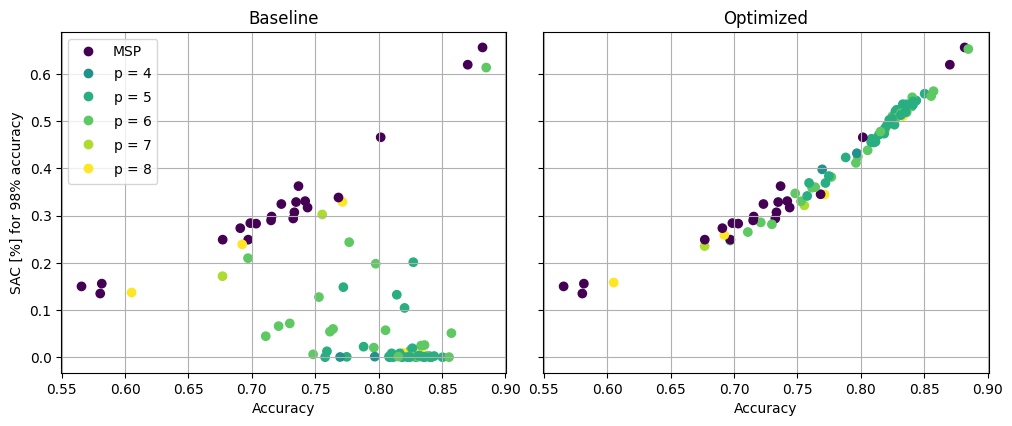

In [16]:

fig,axes = plt.subplots(1,2,figsize = (10,4),sharey = True)
fig.tight_layout()
scatter = axes[0].scatter(acc.values(),d_baseline_sac[ACC].values(),c = optimal_p)
axes[1].scatter(acc.values(),d_sac_opt[ACC].values(),c = optimal_p)
axes[0].set_title('Baseline')
axes[1].set_title('Optimized')
for ax in axes:
    ax.grid()
    ax.set_xlabel('Accuracy')
l = scatter.legend_elements()[1]
for n,i in enumerate(l):
    l[n] = 'p = '+i 
l[0] = 'MSP'

axes[0].set_ylabel('SAC [%] for 98% accuracy')
legend1 = axes[0].legend(scatter.legend_elements()[0], l)
plt.savefig(os.path.join(FIGS_PATH, f'SAC.pdf'), transparent = True, format = 'pdf',bbox_inches = 'tight')
plt.show()

In [14]:
for m in ['efficientnetv2_xl','resnet50','wide_resnet50_2','vgg16','convnext_base','vit_h_14']:
    print(f'SAC 98% {m}: {d_baseline_sac[0.98][m]*100:.2f}')

SAC 98% efficientnetv2_xl: 0.03
SAC 98% resnet50: 0.17
SAC 98% wide_resnet50_2: 0.14
SAC 98% vgg16: 29.79
SAC 98% convnext_base: 0.22
SAC 98% vit_h_14: 61.34
